# Environment setup

In [225]:
import mindspore
import mindspore.dataset as ds
import mindspore.dataset.transforms.c_transforms as C
import mindspore.dataset.vision.c_transforms as CV

In [226]:
from mindspore.common import dtype as mstype
from mindspore.common.initializer import Normal

In [227]:
import mindspore.nn as nn
from mindspore.nn.metrics import Accuracy, Loss

In [228]:
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor, Callback

In [229]:
from mindspore import Model
from mindspore import save_checkpoint, load_checkpoint
from mindspore import context

In [230]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import os, stat

In [231]:
# Configure the MindSpore environment
device_target = context.get_context('device_target')
dataset_sink_mode = True if device_target in ['Ascend', 'GPU'] else False

In [232]:
context.set_context(mode=context.GRAPH_MODE, device_target=device_target)

In [233]:
# print(f'device_target: {device_target}')
# print(f'dataset_sink_mode: {dataset_sink_mode}')

# Data display

In [234]:
train_path = os.path.join('data', '10-batches-bin')  # Path of the training set
test_path = os.path.join('data', '10-verify-bin')  # Path of the test set

In [235]:
print(f' Path of the training set :{train_path}')
print(f' Path of the test set :{test_path}')

 Path of the training set :data/10-batches-bin
 Path of the test set :data/10-verify-bin


In [236]:
# Create an image label list.
category_dict = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog',
                 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

In [237]:
demo_data = ds.Cifar10Dataset(test_path)

In [238]:
plt.figure(figsize=(6, 6))

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

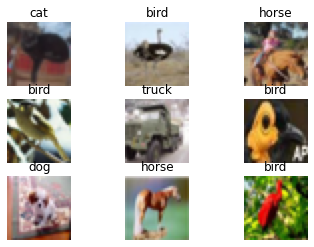

In [239]:
subgraph_counter = 1

for dic in demo_data.create_dict_iterator():
    plt.subplot(3, 3, subgraph_counter)
    plt.imshow(dic['image'].asnumpy())
    plt.axis('off')
    plt.title(category_dict[dic['label'].asnumpy().item()])
    subgraph_counter += 1

    if subgraph_counter > 9:
        break
plt.show()

# Data Processing

In [240]:
# avg value and std of the dataset for normalization
ds_train = ds.Cifar10Dataset(train_path)
tmp = np.asarray([x['image'] for x in ds_train.create_dict_iterator(output_numpy=True)])

RGB_mean = tuple(np.mean(tmp, axis=(0, 1, 2)))
RGB_std = tuple(np.std(tmp, axis=(0, 1, 2)))

print(RGB_mean)
print(RGB_std)

KeyboardInterrupt: 

In [ ]:
def create_dataset(data_path, batch_size=32, repeat_num=1, usage='train'):
    """
    Process data.
    Args:
    data_path (str): data path
    batch_size (int): batch size
    usage (str): training or test
    """
    data = ds.Cifar10Dataset(data_path)
    data = data.shuffle(buffer_size=10000)

    if usage == 'train':
        trans = [
            CV.Normalize(RGB_mean, RGB_std),
            CV.RandomCrop([32, 32], [4, 4, 4, 4]),
            CV.RandomHorizontalFlip(),
            CV.HWC2CHW()
        ]

    else:
        trans = [
            CV.Normalize(RGB_mean, RGB_std),
            CV.HWC2CHW()
        ]

    typecast_op = C.TypeCast(mstype.int32)

    data = data.map(input_columns='label', operations=typecast_op)
    data = data.map(input_columns='image', operations=trans)
    data = data.batch(batch_size, drop_remainder=True)
    data = data.repeat(repeat_num)

    return data

# Network -> LeNet5

In [ ]:
class LeNet5(nn.Cell):
    """
        LeNet5
        Args:
        num_class (int): number of output classes
        num_channel (int): number of input channels
    """

    def __init__(self, num_class=10, num_channel=3):
        super(LeNet5, self).__init__()
        # Convolutional layer
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        # Fully connected layer
        self.fc1 = nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        # Activation function
        self.relu = nn.ReLU()
        # Maximum pooling layer
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Flatten the network.
        self.flatten = nn.Flatten()

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Model Training

In [ ]:
# train/test datasets

In [ ]:
train_data = create_dataset(train_path, batch_size=32, usage='train')
test_data = create_dataset(test_path, batch_size=50, usage='test')

In [ ]:
network1 = LeNet5(10)
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
net_opt = nn.Momentum(params=network1.trainable_params(), learning_rate=0.01, momentum=0.9)
model = Model(network=network1, loss_fn=net_loss, optimizer=net_opt, metrics={'accuracy':
                                                                                  Accuracy(), 'loss': Loss()})

In [ ]:
# loss of each epoch
class TrainHistory(Callback):
    def __init__(self, history):
        super(TrainHistory, self).__init__()
        self.history = history

    def epoch_end(self, run_context):
        cb_params = run_context.original_args()
        loss = cb_params.net_outputs.asnumpy()
        self.history.append(loss)

In [ ]:
# loss and accuracy of the model in the test set -> save network params with the highest accuracy
class EvalHistory(Callback):
    best_param = None

    def __init__(self, model, loss_history, acc_history, eval_data):
        super(EvalHistory, self).__init__()

        self.loss_history = loss_history
        self.acc_history = acc_history
        self.eval_data = eval_data
        self.model = model

    def epoch_end(self, run_context):
        cb_params = run_context.original_args()
        res = self.model.eval(self.eval_data, dataset_sink_mode=False)
        if len(self.acc_history) == 0 or res['accuracy'] >= max(self.acc_history):
            self.best_param = copy.deepcopy(cb_params.network)

        self.loss_history.append(res['loss'])
        self.acc_history.append(res['accuracy'])

        print('acc_eval: ', res['accuracy'])

    def end(self, run_context):
        best_param_path = os.path.join(ckpt_path, 'best_param.ckpt')

        if os.path.exists(best_param_path):
            os.chmod(best_param_path, stat.S_IWRITE)

        save_checkpoint(self.best_param, best_param_path)



In [ ]:
ckpt_path = os.path.join('.', 'results')
history = {'loss': [], 'loss_eval': [], 'acc_eval': []}
config_ck = CheckpointConfig(save_checkpoint_steps=2000,
                             keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix='checkpoint_lenet', directory=ckpt_path, config=config_ck)
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
loss_cb = LossMonitor(per_print_times=500)
train_hist_cb = TrainHistory(history['loss'])
eval_hist_cb = EvalHistory(model=model,
                           loss_history=history['loss_eval'],
                           acc_history=history['acc_eval'],
                           eval_data=test_data)

epoch = 10
model.train(epoch, train_data, callbacks=[train_hist_cb, eval_hist_cb, time_cb, ckpoint_cb, loss_cb],
            dataset_sink_mode=dataset_sink_mode)

# Model Evaluation

In [ ]:
def plot_loss(hist):
    plt.plot(hist['loss'], marker='.')
    plt.plot(hist['loss_eval'], marker='.')
    plt.title('loss record')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.legend(['loss_train', 'loss_eval'], loc='upper right')
    plt.show()
    plt.close()


plot_loss(history)

In [ ]:
def plot_accuracy(hist):
    plt.plot(hist['acc_eval'], marker='.')
    plt.title('accuracy history')
    plt.xlabel('epoch')
    plt.ylabel('acc_eval')
    plt.grid()
    plt.show()
    plt.close()


plot_accuracy(history)

In [ ]:
load_checkpoint(os.path.join(ckpt_path, 'best_param.ckpt'), net=network1)
res = model.eval(test_data, dataset_sink_mode=dataset_sink_mode)
print(res)

# Model Optimization

In [ ]:
class LeNet5_2(nn.Cell):
    def __init__(self, num_class=10, num_channel=3):
        super(LeNet5_2, self).__init__()

        self.conv1 = nn.Conv2d(num_channel, 32, 3, pad_mode='valid', weight_init=Normal(0.02))
        self.conv2 = nn.Conv2d(32, 64, 3, pad_mode='valid', weight_init=Normal(0.02))
        self.conv3 = nn.Conv2d(64, 128, 3, pad_mode='valid', weight_init=Normal(0.02))
        self.fc1 = nn.Dense(128 * 2 * 2, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.num_class = num_class

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

In [ ]:

train_data = create_dataset(train_path, batch_size=32, usage='train')
test_data = create_dataset(test_path, batch_size=50, usage='test')

In [ ]:
network2 = LeNet5_2(10)
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
net_opt = nn.Adam(params=network2.trainable_params())
model = Model(network=network2, loss_fn=net_loss, optimizer=net_opt, metrics={'accuracy': Accuracy(), 'loss': Loss()})

In [ ]:
hist = {'loss': [], 'loss_eval': [], 'acc_eval': []}
config_ck = CheckpointConfig(save_checkpoint_steps=2000, keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix='checkpoint_lenet_2', directory=ckpt_path, config=config_ck)
train_hist_cb = TrainHistory(hist['loss'])
eval_hist_cb = EvalHistory(model=model,
                           loss_history=hist['loss_eval'],
                           acc_history=hist['acc_eval'],
                           eval_data=test_data)

# Retrain and Evaluation

In [ ]:
epoch = 10
model.train(epoch, train_data,
            callbacks=[train_hist_cb, eval_hist_cb, time_cb, ckpoint_cb,
                       LossMonitor(per_print_times=500)],
            dataset_sink_mode=dataset_sink_mode)

In [ ]:
plot_loss(hist)

In [ ]:
plot_accuracy(hist)

In [ ]:
best_param = mindspore.load_checkpoint(os.path.join(ckpt_path, 'best_param.ckpt'), net=network2)
res = model.eval(test_data, dataset_sink_mode=dataset_sink_mode)
print(res)

# Effect Display

In [ ]:
category_dict = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog',
                 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

data_path = os.path.join('data', '10-verify-bin')
demo_data = create_dataset(test_path, batch_size=1, usage='test')


def normalize(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range


plt.figure(figsize=(10, 10))

i = 1

for dic in demo_data.create_dict_iterator():
    input_img = dic['image']
    output = model.predict(input_img)
    predict = np.argmax(output.asnumpy(), axis=1)[0]

    plt.subplot(3, 3, i)

    input_image = np.squeeze(input_img.asnumpy(), axis=0)
    input_image = input_image.transpose(1, 2, 0)
    input_image = normalize(input_image)

    plt.imshow(input_image)
    plt.axis('off')
    plt.title('True: %s\nPredict: %s' % (category_dict[dic['label'].asnumpy().item()], category_dict[predict]))

    i += 1
    if i > 9:
        break

plt.show()

# Quiz

In [ ]:
"""
Questions:

1. Why should the if usage =='train' judgment formula be added before data
argumentation?
2. What are the data augmentation methods? Give examples.
3. What is a step?
4. What base class should I inherit when writing a user-defined callback function?
5. How can I obtain important information (loss function, optimizer, and current epoch
number) during the training process in the user-defined callback function?
6. If a model in this experiment is underfitting, you can optimize the model by increasing
the network complexity. If a model is overfitting, which method can be used to solve the
problem?
7. What is the dataset sink mode?
8. Why does the model's loss value in this experiment fluctuate greatly in the training set
and is higher than that in the test set?
"""

In [ ]:
"""
Answers:

1. Because data augmentation (in this case, cropping and flipping) should only be used on train datasets
2. Data augmentation is used to increase the size of an existing dataset. a) Image rotation; b) blurring; c) rescaling; d) zooming; e) grayscaling; f) random noise; and g) random partial erasing.
3. If it is about saving checkpoint steps, then it means that every x (pre-defined) number of steps records will be saved as a checkpoint.
4. Callback?
5. Passing it into Model and saving epoches in TrainHistory
6. a) Increasing the number of data records (if possible, else data augmentation) b) If the model is complex, use regularization/dropouts. c) To avoid long waiting, an early stopping could be implemented if the overfit (difference between train and validation/test data sets) exceeds a predefined threshold. d) If all of the above fails, try another model or model ensemble (combine separate models predictions).
7. Determines whether the data should be passed through the dataset channel. In this case, either Ascend or GPU (Because I forgot to enable the NVidia GPU drivers, it trained on the CPU, resulting in errors and waited longer.)
8. I'm not entirely certain. Perhaps the training dataset is too small, or there is a need to increase the number of batches/each batch size (add more data records). In any case, more data would improve accuracy (data-centric approach instead of algorithm improvement). Or, as mentioned in lab guide: "The LeNet is not complex enough to produce fitting effect for the CIFAR-10 image
classification task"
"""

# Challenge

In [241]:
# In this experiment, the final model accuracy is still low. Try to improve the model accuracy to over 80%.

In [243]:
# Accuracy approx 81.25%
class LeNet5_3(nn.Cell):
    def init(self, num_class=10, num_channel=3):
        super(LeNet5_3, self).init()

        self.conv1 = nn.Conv2d(num_channel, 64, 3, pad_mode='valid', weight_init=Normal(0.02))
        self.conv2 = nn.Conv2d(64, 128, 3, pad_mode='valid', weight_init=Normal(0.02))
        self.conv3 = nn.Conv2d(128, 128, 3, pad_mode='valid', weight_init=Normal(0.02))
        self.fc1 = nn.Dense(512, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.num_class = num_class

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.max_pool2d(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

In [ ]:
# I assume that it could be improved (did not check) even more with the model structure like:
"""
conv2d->relu->max_pooling->normalization
conv2d->relu->max_pooling->normalization

conv2d->relu->max_pooling->normalization
conv2d->relu->max_pooling->normalization
dropout(not sure though, if model gets complicated)

conv2d->relu->max_pooling->normalization
conv2d->relu->max_pooling->normalization
dropout(not sure though, if model gets complicated)

Flatten
Dense
Relu

(possible even without the last layer, keep it simple)
Flatten
Dense
Relu
"""